<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Looking at Parameter Sensitivity

We have already discussed the Jacobian matrix in a few places. It is calculated by perturbing the parameter (usually 1%) and tracking what happens to each observation.  In a general form the sensitivity equation looks like eq. 9.7 Anderson et al. 2015:

<img src="Sensitivity_eq.png" style="float: center">

This is key for derivative-based parameter estimation because, as we've seen, this allows us to efficiently compute upgraded parameters to try during the lambda search.  But the Jacobian matrix can give us insight about the model in and of itself. 

Let's take a look at it more closely and see what we can learn from it and how to handle such information as the number of parameters rises.

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
from matplotlib.backends.backend_pdf import PdfPages
runall_flag = False
import sensitivity_identifiability_helper as sih

Bring in the model...

In [2]:
import freyberg_setup as fs
fs.setup_pest_kr()
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_KR
pst_name = fs.PST_NAME_KR

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/rjhunt1/GW1876-SD18/activities/freyberg_sensitivity_identifiability/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/22  8:15:28

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time s

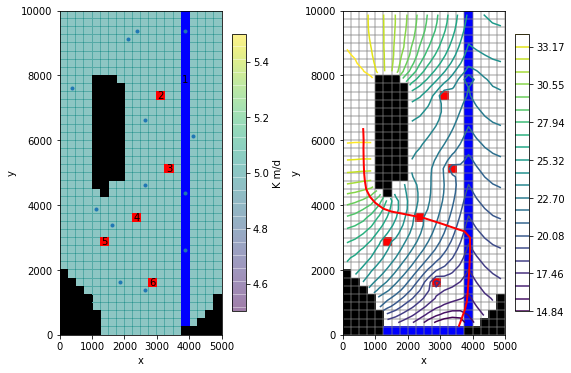

In [3]:
# plot HK field and simulated heads and particle track
fs.plot_model(working_dir, pst_name)

## Bring the PST file into pyemu and find what are the starting values for K and R

In [4]:
# define inpst to represent the PEST model brought in
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# echo out the parameter data
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


### At the top of the notebook we run a single forward model run to test the plumbing when it is brought in. Now let's tell PEST++ to calculate the Jacobian matrix by changing NOPTMAX from 0 to -1 
(recall NOPTMAX=-1 calculates the and all the statistics, to save one run and omit statistics we would choose NOPTMAX=-2)

In [5]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.control_data.noptmax =  -1
# have to write the new PEST control file!
inpst.write(os.path.join(working_dir,pst_name.replace(".pst",".final.pst")))

### Now let's calculate the sensitivity by PEST++
(recall a Jacobian matrix takes a minimum of NPAR + 1, which is 4 runs for this case).  Look at the terminal window to see thr progress.

In [6]:
 pyemu.helpers.run("pestpp {0}".format(pst_name.replace(".pst",".final.pst")),cwd=working_dir)

# We can also calculate one for a more complicated Pilot Points model

In [7]:
inpst = pyemu.Pst(os.path.join(fs.WORKING_DIR_PP,fs.PST_NAME_PP))
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(fs.WORKING_DIR_PP,'freyberg_pp_jac.pst'))

In [8]:
if runall_flag is True:
    os.chdir(fs.WORKING_DIR_PP)
    pyemu.helpers.start_slaves('.', 'pestpp', 'freyberg_pp_jac.pst', num_slaves=15,master_dir='.')
    os.chdir('..')
else:
    if not os.path.exists(fs.WORKING_DIR_PP):
        os.mkdir(fs.WORKING_DIR_PP)
    shutil.copy2('freyberg_pp_jac.jcb',os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb'))

### Look at the Jacobian matrix---gradients of parameters wrt. observations

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### First we can read in a couple Jacobian matrices -- one from our simple model, and one from a more complex one

In [9]:
jac_simple = pyemu.Jco.from_binary(os.path.join(working_dir,'freyberg_kr.final.jcb'))
jac_complex = pyemu.Jco.from_binary(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb'))

### These are now matrices. How big are they?

In [10]:
print ('simple  --> {0} rows x {1} columns'.format(*jac_simple.shape))
print ('complex --> {0} rows x {1} columns'.format(*jac_complex.shape))


simple  --> 1013 rows x 2 columns
complex --> 767 rows x 58 columns


In [11]:
# Let's drop all the forecasts and regularization information
jac_simple.drop([x for x in jac_simple.df().index if x.startswith('pr')], axis=0)
jac_simple.drop([x for x in jac_simple.df().index if x.startswith('fr')], axis=0)
jac_simple.drop('travel_time', axis=0)

jac_complex.drop([x for x in jac_complex.df().index if x.startswith('pr')], axis=0)
jac_complex.drop([x for x in jac_complex.df().index if x.startswith('fr')], axis=0)
jac_complex.drop('travel_time', axis=0)

In [12]:
jac_simple.shape

(1012, 2)

/Users/rjhunt1/GW1876-SD18/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


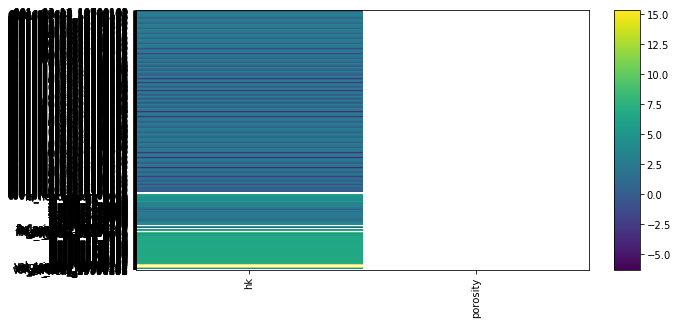

In [13]:
sih.plot_Jacobian(jac_simple)

## how about just the first 20 observations?

/Users/rjhunt1/GW1876-SD18/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


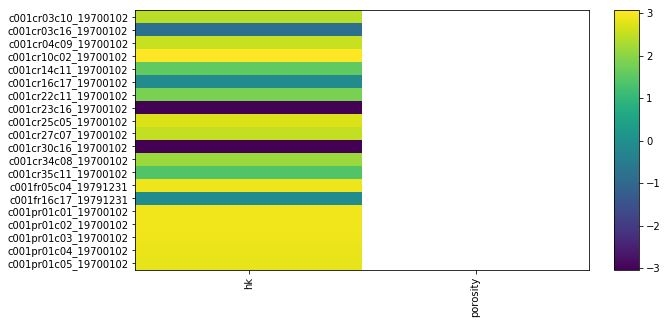

In [14]:
sih.plot_Jacobian(jac_simple[:20,:])

/Users/rjhunt1/GW1876-SD18/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


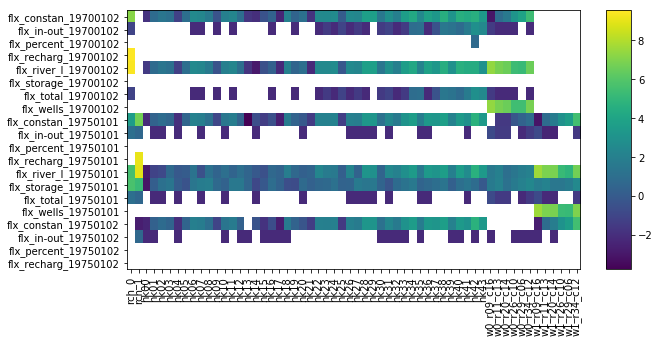

In [15]:
sih.plot_Jacobian(jac_complex[:20,:])

# Can be more informative to look at sensitivity spatially

In [16]:
print(jac_complex.row_names)

['flx_constan_19700102', 'flx_in-out_19700102', 'flx_percent_19700102', 'flx_recharg_19700102', 'flx_river_l_19700102', 'flx_storage_19700102', 'flx_total_19700102', 'flx_wells_19700102', 'flx_constan_19750101', 'flx_in-out_19750101', 'flx_percent_19750101', 'flx_recharg_19750101', 'flx_river_l_19750101', 'flx_storage_19750101', 'flx_total_19750101', 'flx_wells_19750101', 'flx_constan_19750102', 'flx_in-out_19750102', 'flx_percent_19750102', 'flx_recharg_19750102', 'flx_river_l_19750102', 'flx_storage_19750102', 'flx_total_19750102', 'flx_wells_19750102', 'cr03c10_19700102', 'cr03c16_19700102', 'cr04c09_19700102', 'cr10c02_19700102', 'cr14c11_19700102', 'cr16c17_19700102', 'cr22c11_19700102', 'cr23c16_19700102', 'cr25c05_19700102', 'cr27c07_19700102', 'cr30c16_19700102', 'cr34c08_19700102', 'cr35c11_19700102', 'vol_constan_19700102', 'vol_in-out_19700102', 'vol_percent_19700102', 'vol_recharg_19700102', 'vol_river_l_19700102', 'vol_storage_19700102', 'vol_total_19700102', 'vol_wells_19

ValueError: c of shape (44,) not acceptable as a color sequence for x with size 32, y with size 32

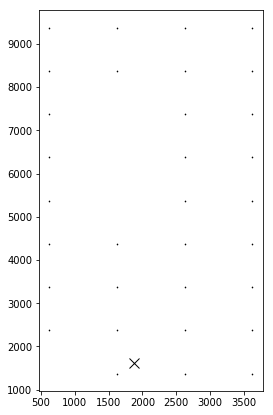

In [17]:
sih.plot_jacobian_spatial(jac_complex,'cr34c08_19700102');

ValueError: c of shape (44,) not acceptable as a color sequence for x with size 32, y with size 32

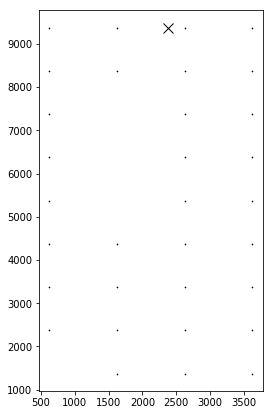

In [18]:
with PdfPages('allsens.pdf') as ofp:
    for cob in jac_complex.row_names:
        if 'flx' not in cob and 'vol' not in cob:
            cf = sih.plot_jacobian_spatial(jac_complex, cob)
            ofp.savefig()
            plt.close('all')

# How about Composite Scaled Sensitivities
In the traditional, overdetermined regression world, CSS was a popular metric. CSS is Composite Scaled Sensitivitity.

In Hill and Tiedeman (2007) this is calculated as: 
## ${css_{j}=\sqrt{\left(\sum_{i-1}^{ND}\left(\frac{\partial y'_{i}}{\partial b_{j}}\right)\left|b_{j}\right|\sqrt{w_{ii}}\right)/ND}}$

In PEST, Doherty calculates it slightly differently in that scaling by the parameter values happens automatically when the parameter is subjected to a log-transform. This is due to a correction that must be made in calculating the Jacobian matrix and follows from the chain rule of derivatives.


In [19]:
la = pyemu.LinearAnalysis(jco=os.path.join(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb')))

Exception: forecast argument: fa_headwaters_0001 not found in jco row names and could not be loaded from a file.

In [ ]:
plt.figure(figsize=(8,4))
ax = la.get_par_css_dataframe()['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

### Now let's consider correlation and posterior covariance

In [ ]:
sc = pyemu.Schur(os.path.join(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

In [ ]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

In [ ]:
cpar = 'hk10'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

In [ ]:
R_plot = R.df().as_matrix()
R_plot[np.abs(R_plot)>.9] = np.nan
plt.imshow(R_plot, interpolation='nearest', cmap='viridis')
plt.colorbar()